In [1]:
import functools
import time

import jax
import jax.numpy as jnp
import jax.random
import diffrax
import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [2]:
def plot_time_series(U,t, labels=None, t_lim = None, figsize = (20,8), **kwargs):
    '''
    Plots time series data with separate panels for each state variable.

    INPUTS:
        U: 2D array of shape (Nu, Nt) where Nu is the number of state variables and Nt is the number of time points
        t: 1D array of time points
        labels: list of strings containing the names of the state variables
        t_lim: limit for the x-axis
        **kwargs: additional arguments to pass to plot
    '''
    if t_lim is None:
        t_lim = t[-1]
    kwargs.setdefault('linewidth', 2)
    fig, axs = plt.subplots(U.shape[0], figsize = figsize)
    for i in range(U.shape[0]):
        axs[i].plot(t, U[i,:], **kwargs)
        axs[i].set_xlim([0,t_lim])
        if labels is not None:
            axs[i].set(ylabel=labels[i])
    axs[-1].set(xlabel=r't')
    plt.show()

def imshow_1D_spatiotemp(U, TN, domain=(0,1), figsize=(20, 6), title = None, **kwargs):
    '''
    Plot 1D spatiotemporal data using imshow. 
    Author: Dima Tretiak

    INPUTS:
        U: 2D array of shape (Nx, NT) where Nx is the number of spatial points and NT is the number of time points
        TN: final time
        domain: tuple of length 2 containing the bounds of the spatial domain
        title: string containing the title of the plot, if None no title is shown
        **kwargs: additional arguments to pass to imshow
    '''

    #set defaults for imshow
    kwargs.setdefault('aspect', 'auto')
    kwargs.setdefault('origin', 'lower')
    kwargs.setdefault('cmap', 'RdGy')
    kwargs.setdefault('extent', [0, TN, domain[0], domain[1]])

    plt.figure(figsize=figsize, dpi=300)
    plt.imshow(U, **kwargs)
    plt.ylabel('x')
    plt.xlabel('t')
    if title is not None:
        plt.title(title)
    plt.colorbar(pad = 0.01, label = r'$u$')
    plt.show()
    
# TODO: Plot attractor, imshow 1d spatiotemp, edit above to use U list 

# systems to implement:
- "basic"
    - lorenz63
    - rossler  
    - sakaraya 
    - colpitts
- hamiltonian
    - double pendulum 
- PDE
    - KS
    - lorenz96

# basic

In [3]:
### Lorenz
def lorenz63_f(t,y, args):
    rho, sigma, beta = args
    y1, y2, y3 = y
    dy1dt = sigma*(y2 - y1)
    dy2dt = y1*(rho - y3) - y2
    dy3dt = y1*y2 - beta*y3
    dydt = dy1dt, dy2dt, dy3dt
    return jnp.array(dydt)

TN = 20
term = diffrax.ODETerm(lorenz63_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = 28.0, 10.0, 8.0/3.0
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = jnp.array([1,1,1]), dt0 = 0.1, saveat=saveat, args=args)


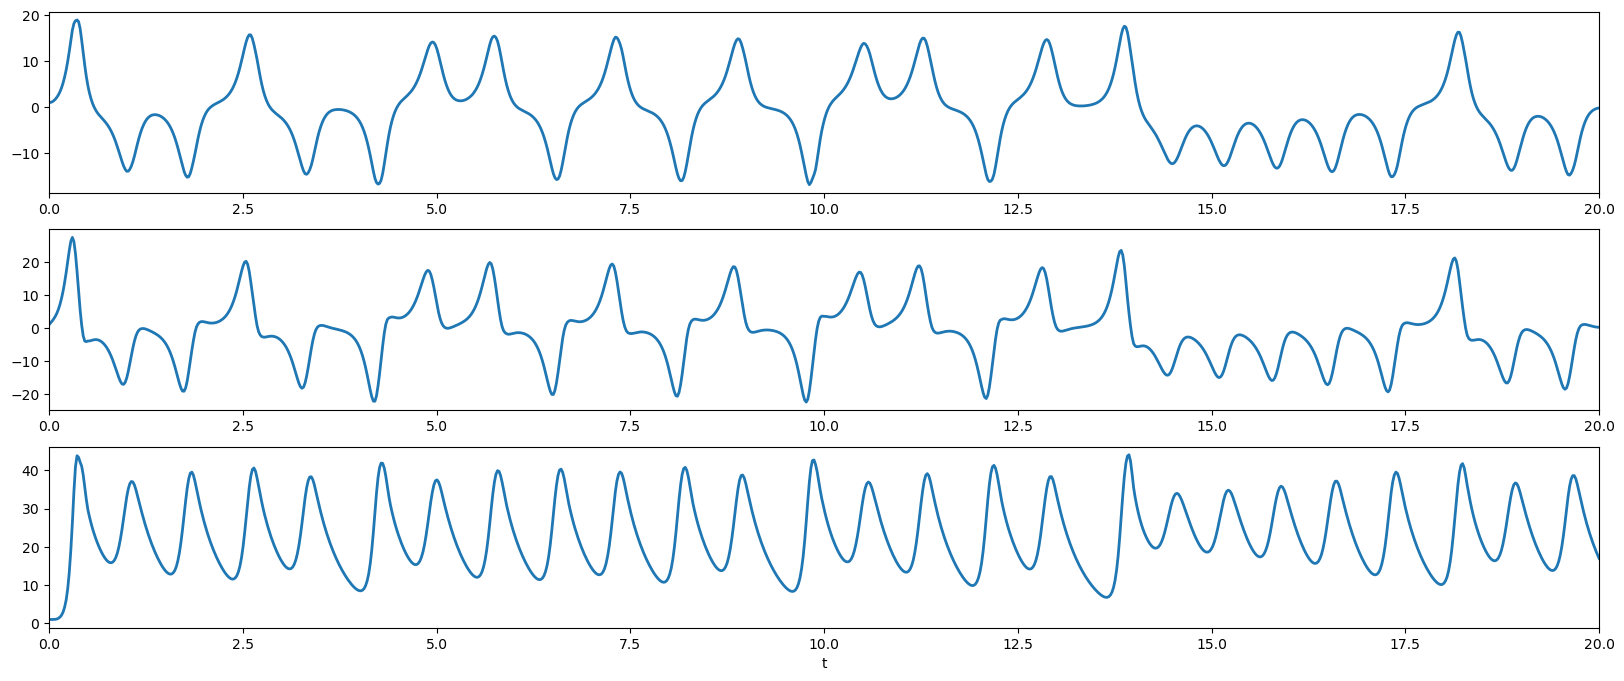

In [4]:
plot_time_series(sol.ys.T, sol.ts)

In [5]:
### Rossler 
@jax.jit
def rossler_f(t,y, args):
    a,b,c = args
    y1, y2, y3 = y
    dy1dt = -y2 - y3
    dy2dt = y1 + a*y2
    dy3dt = b+y3*(y1-c)
    dydt = dy1dt, dy2dt, dy3dt
    return jnp.array(dydt)

TN = 100
term = diffrax.ODETerm(rossler_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = 0.1, 0.1, 14
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = jnp.array([1,1,1]), dt0 = 0.1, saveat=saveat, args=args)

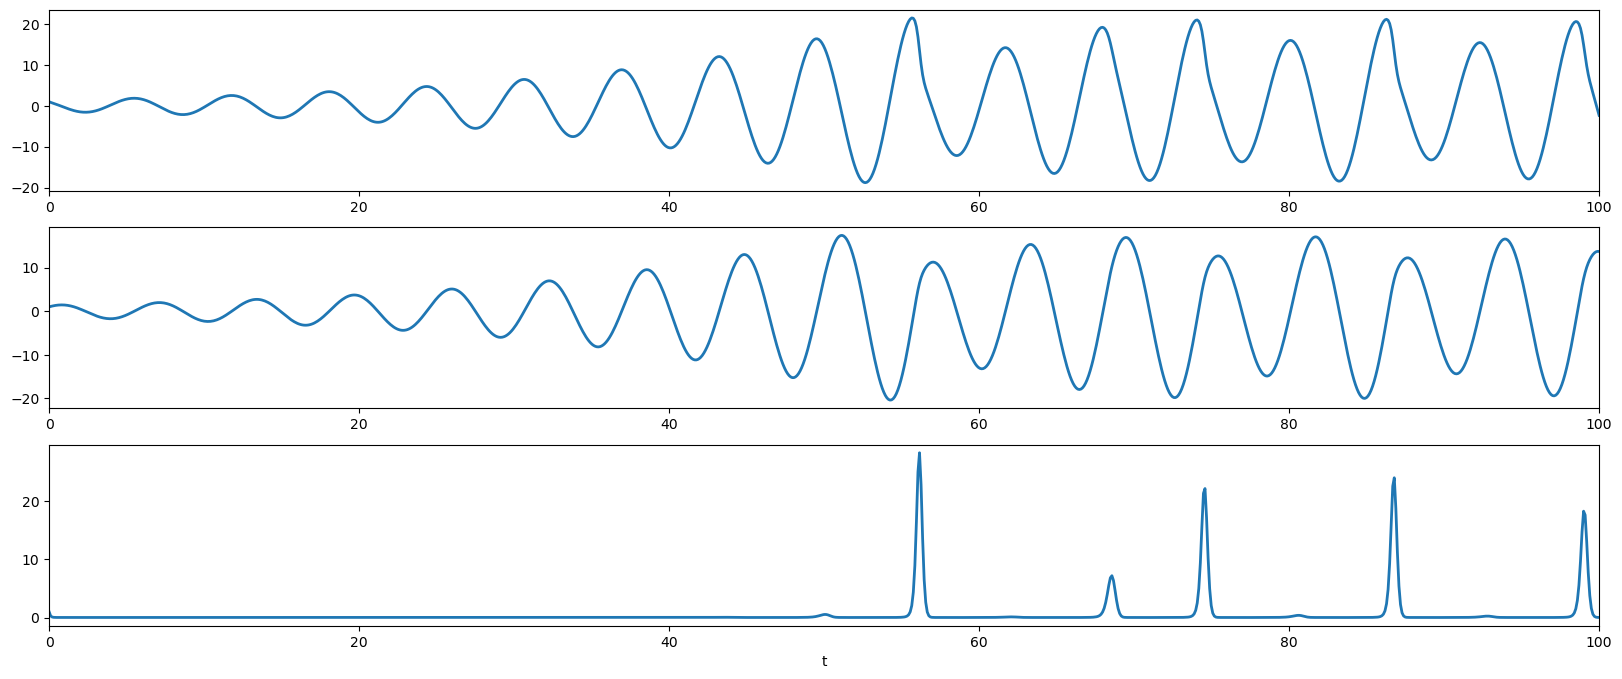

In [6]:
plot_time_series(sol.ys.T, sol.ts)

In [7]:
### Double Pendulum 
@jax.jit
def double_pendulum_f(t, y, args):
    a, b, m = args
    y1, y2, y3 = y

    dy1dt = a * y1 + y2 + y2*y3
    dy2dt = -y1*y3 + y2*y3
    dy3dt = -y3 - m*y1*y2 + b

    return jnp.array([dy1dt, dy2dt, dy3dt])

TN = 40
term = diffrax.ODETerm(double_pendulum_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
y0 = jnp.array([-2.8976045, 3.8877978, 3.07465])
args = 1,1,1 # a, m, b 
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = y0, dt0 = 0.1, saveat=saveat, args=args)

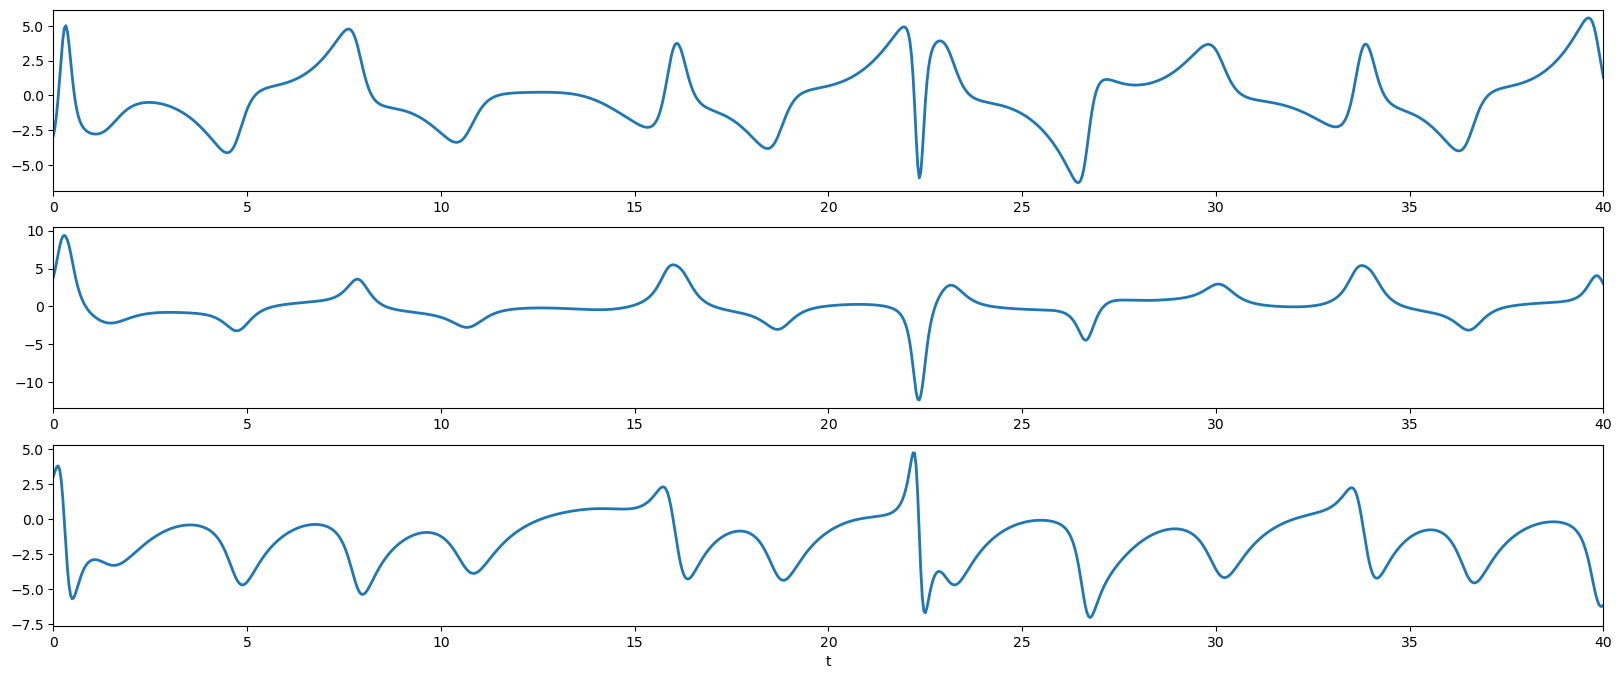

In [8]:
plot_time_series(sol.ys.T, sol.ts)

# Hamiltonian 

In [9]:
### Double Pendulum 
@jax.jit
def double_pendulum_f(t, y, args):
    m1, m2, L1, L2, g, damping = args
    theta1, omega1, theta2, omega2 = y

    #define some vars to shorten the expressions
    delta_theta = theta1 - theta2
    M_tot = m1 + m2
    alpha = m1 + m2*jnp.sin(delta_theta)**2

    # compute derivs
    dtheta1_dt = omega1
    dtheta2_dt = omega2
    domega1_dt = (-jnp.sin(delta_theta) * (m2*L1*omega1**2*jnp.cos(delta_theta) + m2*L2*omega2**2) - g*(M_tot * jnp.sin(theta1) - m2*jnp.sin(theta2)*jnp.cos(delta_theta))) / (L1*alpha) - damping*(omega1-omega2) - damping*omega1
    domega2_dt = (jnp.sin(delta_theta) *(M_tot*L1*omega1**2 + m2*L2*omega2**2*jnp.cos(delta_theta)) + g*(M_tot*jnp.sin(theta1)*jnp.cos(delta_theta) - M_tot*jnp.sin(theta2))) / (L2*alpha) - damping*(omega2-omega1)

    return jnp.array([dtheta1_dt, domega1_dt, dtheta2_dt, domega2_dt])

TN = 20
term = diffrax.ODETerm(double_pendulum_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = 1.0, 1.0, 1.0, 1.0, 9.81, 0.0 # m1, m2, L1, L2, g, c
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = jnp.array([1,1,1,1]), dt0 = 0.1, saveat=saveat, args=args)

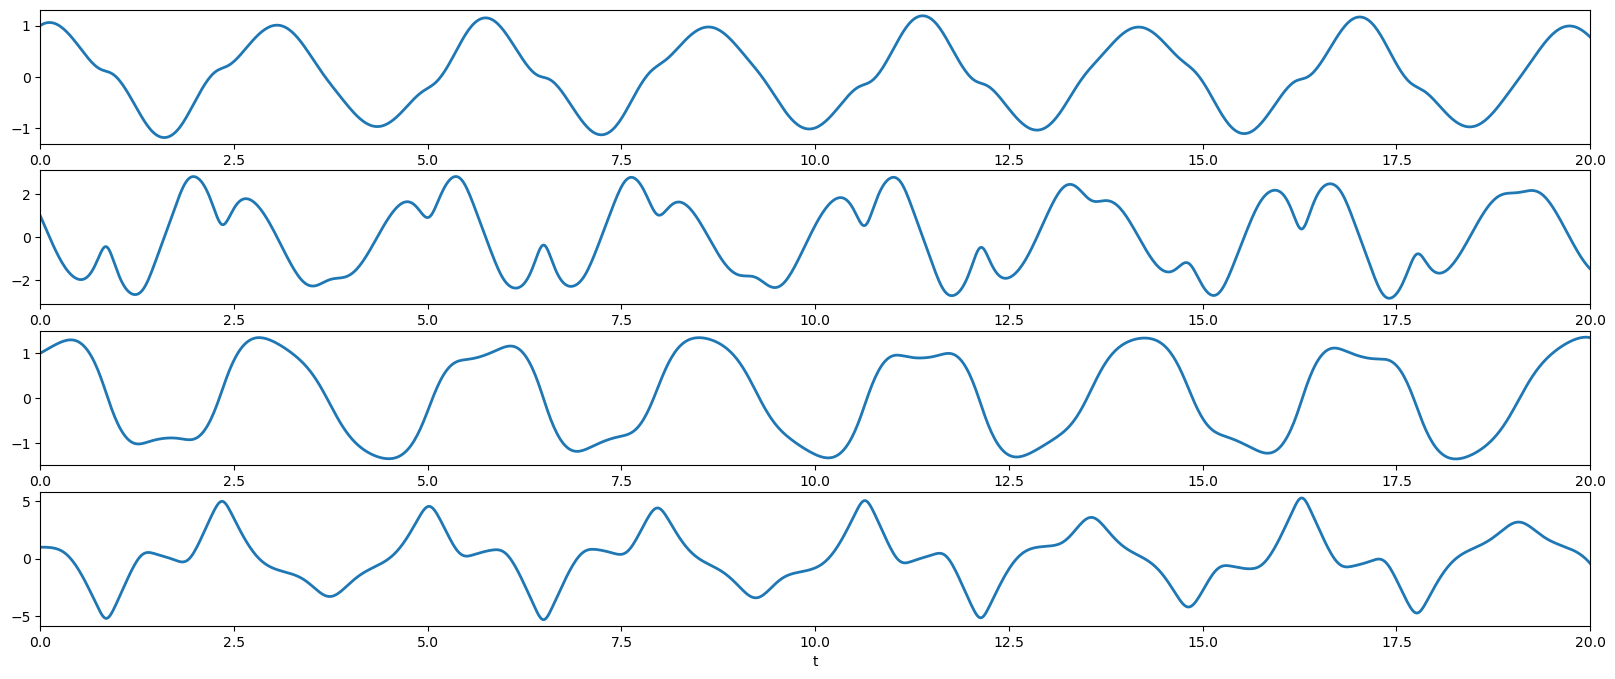

In [10]:
plot_time_series(sol.ys.T, sol.ts)

# High dim systems 

In [11]:
### Lorenz96
@jax.jit
def _loren96_interior(i,y,F):
    return (y[i+1] - y[i-2])*y[i-1]-y[i] + F

@functools.partial(jax.jit, static_argnames=["args"])
def lorenz96_f(t,y,args):
    N, F = args

    # boundary at N
    dydt_N = (y[0] - y[N-3])*y[N-2]-y[N-1] + F

    # calculate all other points (interior plus boundary at 0)
    dydt_func = jax.vmap(_loren96_interior, in_axes=(0,None,None))
    interior_idxs = jnp.arange(N-1)
    dydt_interior = dydt_func(interior_idxs, y, F)

    return jnp.append(dydt_interior, dydt_N)

TN = 40
N = 200
F = 8.0
term = diffrax.ODETerm(lorenz96_f)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, TN, 1000))
args = N, F
key = jax.random.PRNGKey(0)
y0 = jax.random.normal(key, N)
sol = diffrax.diffeqsolve(term, solver, 0, TN, y0 = y0, dt0 = 0.1, saveat=saveat, args=args)

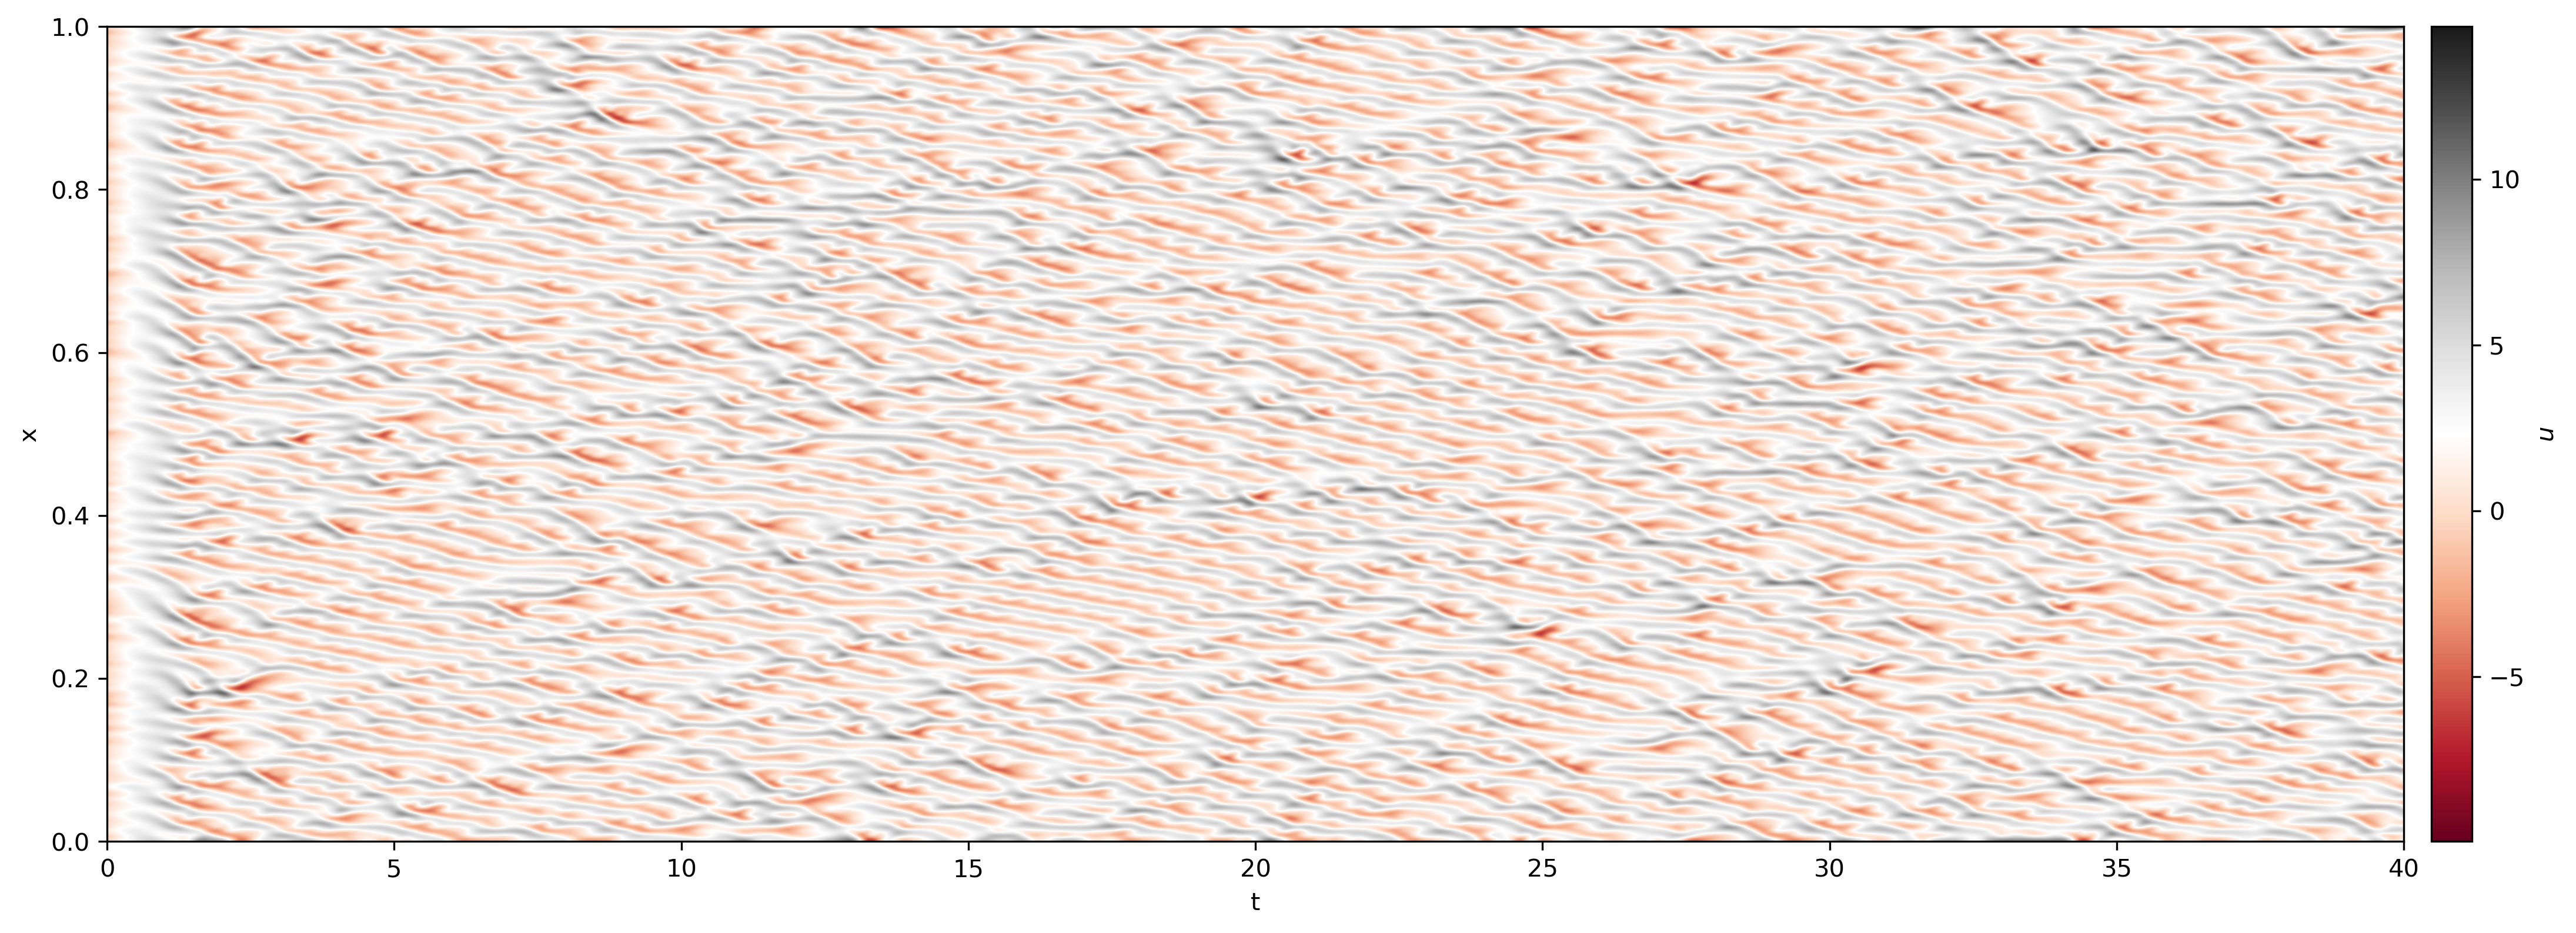

In [12]:
imshow_1D_spatiotemp(sol.ys.T, sol.ts[-1], interpolation = 'bicubic')

In [58]:
@functools.partial(jax.jit, static_argnames=["tN", "dt", "Nx"])
def KS_1D_PBC_jax(u0, tN, dt=0.1, domain=(0, 100), Nx=200):
    # Setup spatial grid
    Nx = Nx - 1  # remove duplicate periodic point
    u0 = u0[:-1]
    x = jnp.linspace(domain[0], domain[1], Nx, endpoint=False)
    dx = x[1] - x[0]
    
    Nt = int(tN / dt)
    U = jnp.zeros((Nx, Nt))
    U = U.at[:, 0].set(u0)

    # Wavenumbers
    k = jnp.fft.fftfreq(Nx, d=dx) * 2 * jnp.pi
    k2 = k**2
    k4 = k**4
    L_op = k2 - k4

    # Dealiasing (2/3 rule)
    def dealias(f_hat):
        cutoff = Nx // 3
        f_hat = f_hat.at[cutoff:-cutoff].set(0)
        return f_hat

    # nonlinear operators on u and u_hat 
    N_op_u = lambda u: dealias(1j * k * jnp.fft.fft(-0.5 * u ** 2))
    N_op_uhat = lambda u_hat: dealias(1j * k * jnp.fft.fft(-0.5 * jnp.real(jnp.fft.ifft(u_hat)) ** 2))

    # ETDRK4 coefficients (Kassam & Trefethen 2005)
    E1 = jnp.exp(L_op * dt)
    E2 = jnp.exp(L_op * dt / 2)
    M = 16
    r = jnp.exp(1j * jnp.pi * (jnp.arange(1, M + 1) - 0.5) / M)
    LR = dt * jnp.column_stack([L_op]*M) + jnp.vstack([r]*Nx)
    Q = dt * jnp.mean((jnp.exp(LR/2) - 1) / LR, axis=1)
    f1 = dt * jnp.mean((-4 - LR + jnp.exp(LR)*(4 - 3*LR + LR**2)) / LR**3, axis=1)
    f2 = dt * jnp.mean((2 + LR + jnp.exp(LR)*(-2 + LR)) / LR**3, axis=1)
    f3 = dt * jnp.mean((-4 - 3*LR - LR**2 + jnp.exp(LR)*(4 - LR)) / LR**3, axis=1)

    def _KS_ETDRK4_step(carry, _):
        u, E1, E2, Q, f1, f2, f3 = carry 

        u_hat = jnp.fft.fft(u)

        a = E2 * u_hat + Q * N_op_u(u)
        b = E2 * u_hat + Q * N_op_uhat(a)
        c = E2 * a + Q * (2*N_op_uhat(b) - N_op_u(u))

        u_hat = E1 * u_hat + f1 * N_op_u(u) + f2 * (N_op_uhat(a) + N_op_uhat(b)) + f3 * N_op_uhat(c)

        # Enforce conservation by zeroing the mean mode
        u_hat = u_hat.at[0].set(0.0)

        u_next = jnp.real(jnp.fft.ifft(u_hat, n=Nx))
        carry_next = (u_next, E1, E2, Q, f1, f2, f3)
        return carry_next, u_next
    
    _, u_vals = jax.lax.scan(_KS_ETDRK4_step, (u0, E1, E2, Q, f1, f2, f3), length=Nt-1)

    # add back in the initial point and boundary points
    U = jnp.concatenate([u0[None,:], u_vals], axis=0)
    U = jnp.concatenate((U,U[:,0:1]), axis=1)

    # create time vector for output
    t = jnp.arange(0, tN, dt)

    return U,t

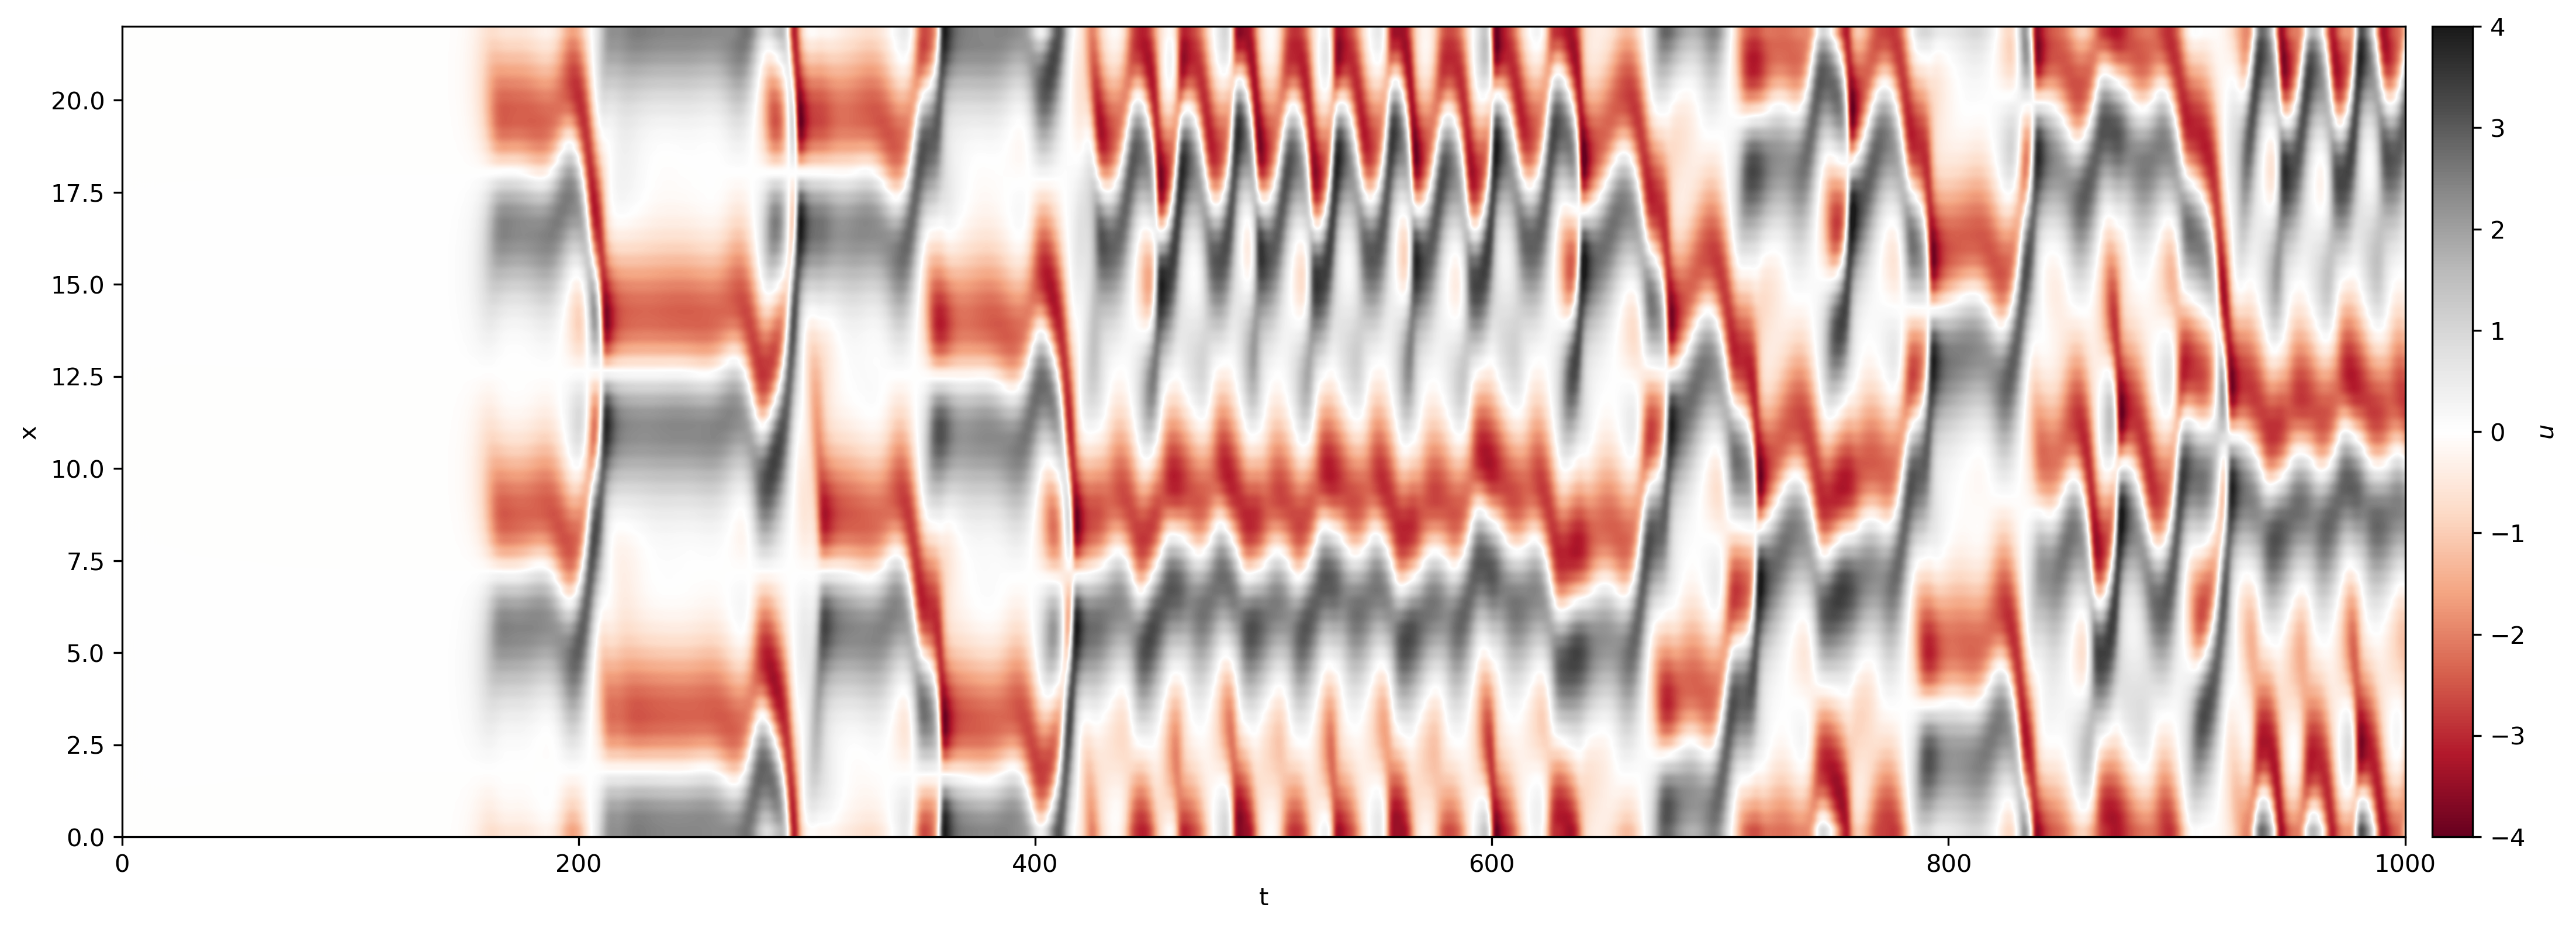

In [59]:
domain = (0, 22) # x in [0, 32*pi]
Nx = 64 # number of spatial points
x0 = jnp.linspace(domain[0], domain[1], Nx, endpoint=True) 
u0 = jnp.sin((32/domain[1])*jnp.pi * x0)
TN = 1000 # final time
dt = 0.25  # time step
U,t = KS_1D_PBC_jax(u0, TN, dt, domain, Nx) # Solve!
imshow_1D_spatiotemp(U.T, TN, domain, vmax = 4.0, vmin = -4.0)